# 텍스트를 위한 딥러닝

## TF-IDF를 이용한 텍스트 딥러닝

### TF-IDF
* 정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치
* 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용한다.
* TF는 Term Frequency의 약자로 어떤 단어가 특정 문서에 얼마나 많이 쓰였는지 빈도를 나타낸다.
* DF는 Document Frequency의 약자로 특정 단어가 나타나는 문서 수이다.(A라는 단어가 말뭉치 전체에서 문서1, 문서3에만 등장했다고 한다면 DF는 2가 된다. DF가 클수록 다수의 문장에서 쓰이는 단어라고 판단할 수 있다)
* IDF는 전체 문서수를 해당 단어의 DF로 나눈 뒤 로그를 취해준 값, 그 값이 클수록 특이한 단어이다.

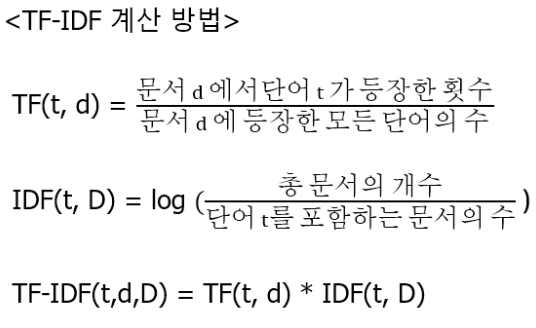

In [1]:
# 데이터 다운로드
!mkdir aclImdbr_tf-idf
!tar -xf aclImdb_v1.tar.gz -C aclImdbr_tf-idf

In [2]:
# unsup 폴더 삭제
!rm -r aclImdbr_tf-idf/aclImdb/train/unsup

In [3]:
# 데이터 준비
import os, pathlib, shutil, random

# 기본 경로 설정
base_dir = pathlib.Path('aclImdbr_tf-idf/aclImdb')

# 검증 데이터 경로 설정
val_dir = base_dir / 'val'

# 학습 데이터 경로 설정
train_dir = base_dir / 'train'

# 'neg'와 'pos' 두 카테고리에 대해 반복문 실행
# neg: 부정적 리뷰, pos: 긍정적 리뷰
for category in ('neg', 'pos'):
    # 각 카테고리에 대한 검증 데이터셋 디렉토리를 생성
    os.makedirs(val_dir / category)
    
    # 현재 카테고리의 훈련 데이터셋 디렉토리에서 모든 파일 목록을 가져와 files변수에 저장
    files = os.listdir(train_dir / category)
    
    # 시드값 1337으로 files변수에 저장된 파일들을 무작위로 섞는다
    random.Random(1337).shuffle(files)
    
    # 훈련 데이터셋에서 검증 데이터셋으로 사용할 파일 수 결정
    num_val_samples = int(0.2 * len(files))
    
    # 섞인 파일 목록에서 검증 데이터로 사용할 파일들을 추출
    val_files = files[-num_val_samples:]
    
    # 추출된 검증 데이터 파일들을 순회
    for fname in val_files:
        # 각 파일을 훈련 데이터셋 디렉토리에서 검증 데이터셋 디렉토리로 이동한다
        shutil.move(train_dir / category / fname, val_dir / category / fname)

In [4]:
from tensorflow import keras

# 배치 사이즈 32로 설정
batch_size = 32

# 학습데이터셋
train_ds = keras.utils.text_dataset_from_directory('aclImdbr_tf-idf/aclImdb/train', batch_size = batch_size)
val_ds = keras.utils.text_dataset_from_directory('aclImdbr_tf-idf/aclImdb/val', batch_size = batch_size)
test_ds = keras.utils.text_dataset_from_directory('aclImdbr_tf-idf/aclImdb/test', batch_size = batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [5]:
from keras.layers import TextVectorization
# 출력 인코딩이 tf_idf인 경우 TF-IDF 가중치 적용
text_vectorization = TextVectorization(ngrams = 2, max_tokens = 20000, output_mode = 'tf_idf')
    
text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorization.adapt(text_only_train_ds)

In [6]:
from tensorflow import keras
from keras import layers

def get_model(max_tokens = 20000, hidden_dim = 16):
    # 함수형 API를 사용한 레이어 생성
    # 입력 텐서 정의
    inputs = keras.Input(shape = (max_tokens, ))
    x = layers.Dense(hidden_dim, activation = 'relu')(inputs)
    # 드롭아웃 레이어
    x = layers.Dropout(0.5)(x)
    # 출력 레이어
    outputs = layers.Dense(1, activation = 'sigmoid')(x)
    # 모델 생성
    model = keras.Model(inputs, outputs)
    
    # 모델 컴파일
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [7]:
import tensorflow as tf

# 어휘사전을 적용하여 학습/검증/평가 데이터 변환한다
tfidf_2gram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)
tfidf_2gram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)
tfidf_2gram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)

# 모델 생성
model = get_model()

# 모델 요약
model.summary()

# 사용자 콜백 작성
callbacks = [
    keras.callbacks.ModelCheckpoint('tfidf_2gram.keras', save_best_only = True)
]

# 모델 학습
model.fit(tfidf_2gram_train_ds.cache(), validation_data = tfidf_2gram_val_ds.cache(), epochs = 10, callbacks = callbacks)

# best모델 로드
model = keras.models.load_model('tfidf_2gram.keras')

# 평가 결과 출력
print(f'테스트 정확도: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 12s 19ms/step - loss: 0.5014 - accuracy: 0.8041 - val_loss: 0.2998 - val_accuracy: 0.8854
Epoch 2/10
625/625 [=======================

In [8]:
# 문자열 1개를 input data로 받아 긍,부정을 분류하는 신규 모델 생성
# 입력레이어
inputs = keras.Input(shape = (1, ), dtype = 'string')
# 텍스트 벡터화 레이어; ngrams=2, max_tokens=20000, output_mode="tf_idf"
processed_inputs = text_vectorization(inputs)
# 출력 레이어
outputs = model(processed_inputs)
# 모델 생성
inference_model = keras.Model(inputs, outputs)

In [9]:
import tensorflow as tf
# 문자열을 텐서로 변환
raw_text_data = tf.convert_to_tensor([
    ['I hate this movie.'],
])
# That was an excellent movie, I loved it.
# 분휴 수행
predictions = inference_model(raw_text_data)

# 결과 출력
print(f'긍정적인 리뷰일 확률: {float(predictions[0] * 100):.2f} 퍼센트')

긍정적인 리뷰일 확률: 42.06 퍼센트


In [10]:
# 문자열을 텐서로 변환
raw_text_data = tf.convert_to_tensor([
    ['I love this movie.'],
])
# That was an excellent movie, I loved it.
# 분류 수행
predictions = inference_model(raw_text_data)

# 결과 출력
print(f'긍정적인 리뷰일 확률: {float(predictions[0] * 100):.2f} 퍼센트')

긍정적인 리뷰일 확률: 75.05 퍼센트


## 시퀀스 모델을 이용한 텍스트 딥러닝

In [11]:
# 데이터 다운로드
!mkdir aclImdbr_sequence
!tar -xf aclImdb_v1.tar.gz -C aclImdbr_sequence

In [12]:
# unsup 폴더 삭제
!rm -r aclImdbr_sequence/aclImdb/train/unsup

In [13]:
import os, pathlib, shutil, random
# 기본 경로 설정
base_dir = pathlib.Path('aclImdbr_sequence/aclImdb')
# 검증 데이터 경로 설정
val_dir = base_dir / 'val'
# 학습 데이터 경로 설정
train_dir = base_dir / 'train'

# 긍/부정 카테고리별로 순회
for category in ('neg', 'pos'):
    # 각 카테고리에 대한 검증 데이터셋 디렉토리 생성
    os.makedirs(val_dir / category)
    
    # 현대 카테고리의 훈련 데이터셋 디렉토리에서 모든 파일 목록을 가져와 files 변수에 저장
    files = os.listdir(train_dir / category)
    
    # 시드값 1337으로 files 변수에 저장된 파일들을 무작위로 섞는다
    random.Random(1337).shuffle(files)
    
    # 훈련데이터셋에서 검증 데이터셋으로 사용할 파일 수 결정
    num_val_samples = int(0.2 * len(files))
    
    # 섞인 파일 목록에서 검증 데이터로 사용할 파일들을 추출
    val_files = files[-num_val_samples:]
    
    # 추출된 검증 데이터 파일들을 순회
    for fname in val_files:
        # 각 파일을 훈련데이터셋 디렉토리에서 검증 데이터셋 디렉토리로 이동
        shutil.move(train_dir / category / fname, val_dir / category / fname)

In [14]:
from tensorflow import keras

# 배치 사이즈
batch_size = 32

# 학습데이터
train_ds = keras.utils.text_dataset_from_directory('aclImdbr_sequence/aclImdb/train', batch_size = batch_size)
# 검증데이터
val_ds = keras.utils.text_dataset_from_directory('aclImdbr_sequence/aclImdb/val', batch_size = batch_size)
# 평가데이터
test_ds = keras.utils.text_dataset_from_directory('aclImdbr_sequence/aclImdb/test', batch_size = batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### 정수 시퀀스 데이터셋 준비

In [15]:
from keras import layers

max_tokens = 20000

# 텍스트 벡터화 레이어 생성
# 정수 인코딩
# 벡터화된 텍스트 시퀀스 길이 설정: 서로 다른 시퀀스를 동일한 길이로 패딩하거나 잘라내어 모든 시퀀스를 동일한 길이로 만든다
text_vectorization = layers.TextVectorization(max_tokens = max_tokens, output_mode = 'int', output_sequence_length = 600)

# 학습데이터셋에서 텍스트 데이터만 추출하여 text_only_train_ds에 저장
# train_ds 데이터셋에 대해 map 함수를 적용하여 모든 샘플에서 x값만을 추출
text_only_train_ds = train_ds.map(lambda x, y: x)

# text_only_train_ds로 어휘사전 생성
text_vectorization.adapt(text_only_train_ds)

# 학습데이터 셋의 텍스트 데이터에 어휘사전을 적용한 후 저장
# num_parallel_calls = 4: 전처리 작업을 4개로 병렬작업
int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)
# 검증데이터 셋의 텍스트 데이터에 어휘사전을 적용한 후 저장
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)
# 평가데이터 셋의 텍스트 데이터에 어휘사전을 적용한 후 저장
int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y), num_parallel_calls = 4)

## 순환신경망(Recurrent Neural Network, RNN)

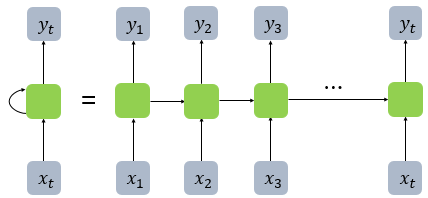

* 순서를 가진 데이터를 입력하여 단위 간 연결이 시퀀스를 따라 방향성 그래프를 형성하는 신경네트워크 모델
* 내부상태(메모리)를 이용하여 입력 시퀀스를 처리한다.
* CNN과는 달리 중간층(은닉층)이 순환구조로 동일한 가중치를 공유한다.(확률적 경사하강법 이용)
* 가중치 업데이트를 위해 과거시점까지 역전파하는 BPTT활용
* 입력 시점마다 가중치가 공유되며, 계산 기울기는 현재 상태와 이전 상태에 대해 의존적이므로, 순차적 데이터 처리에 유용하다.

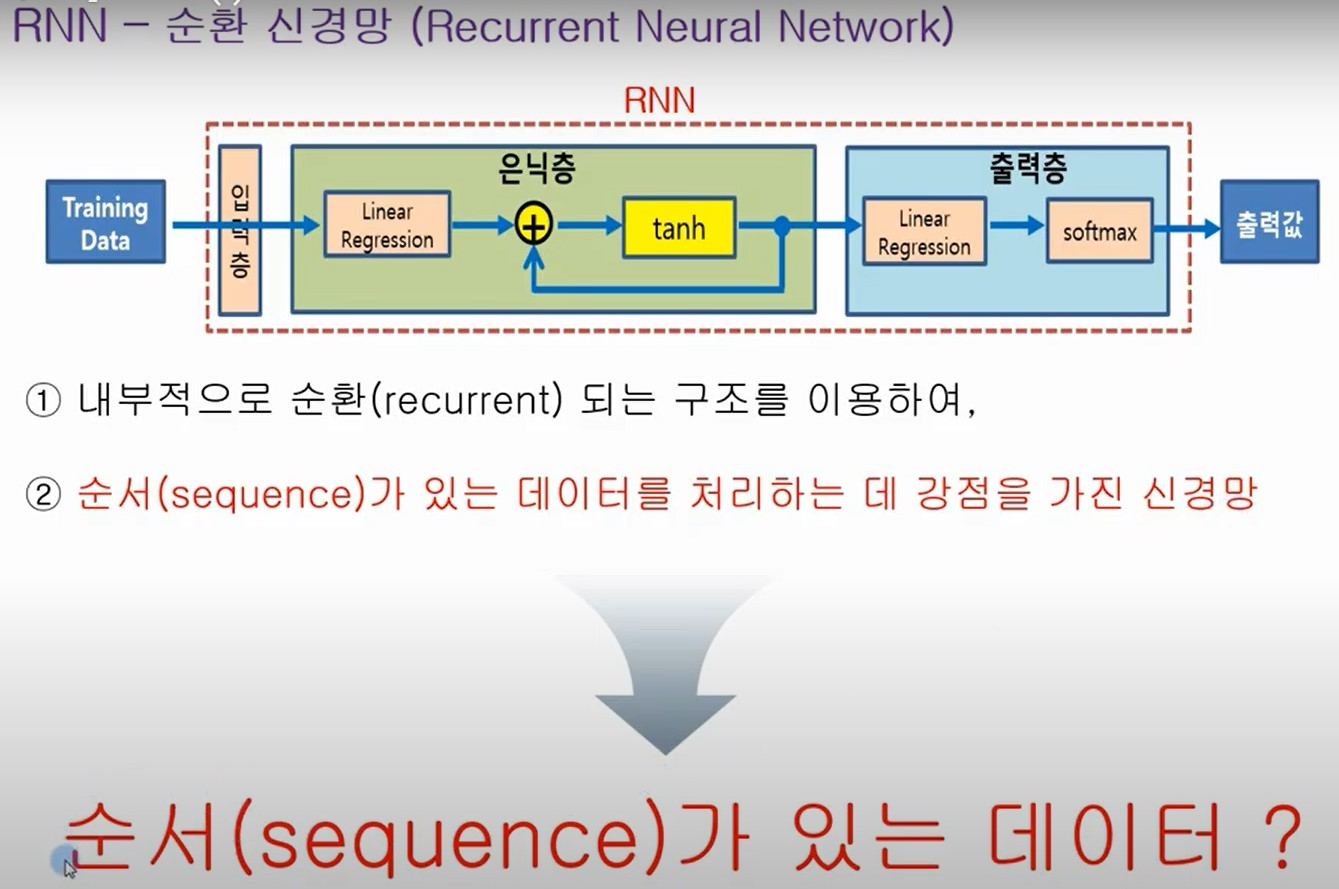

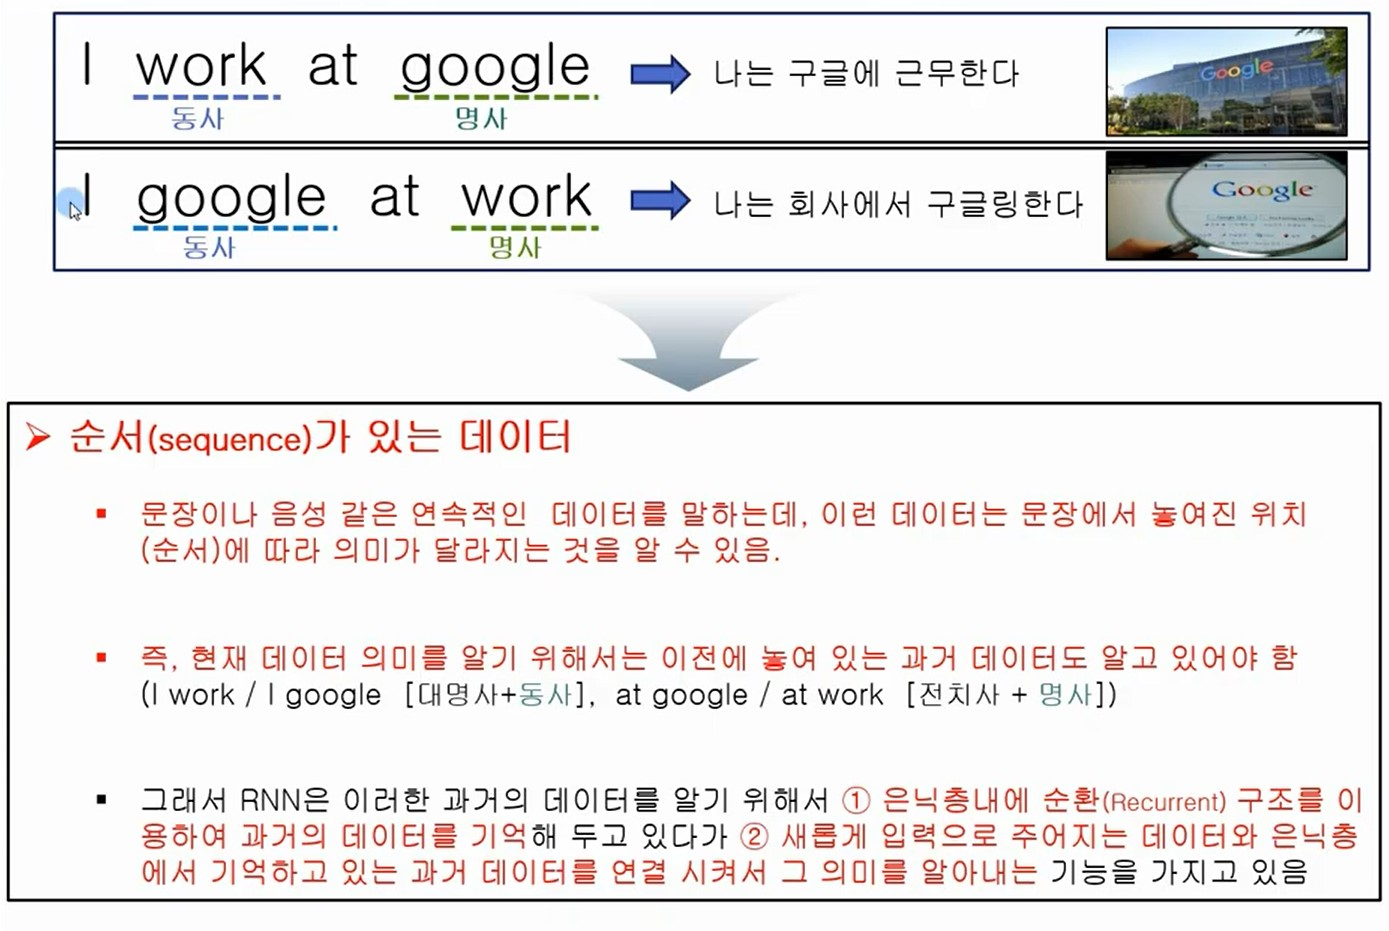

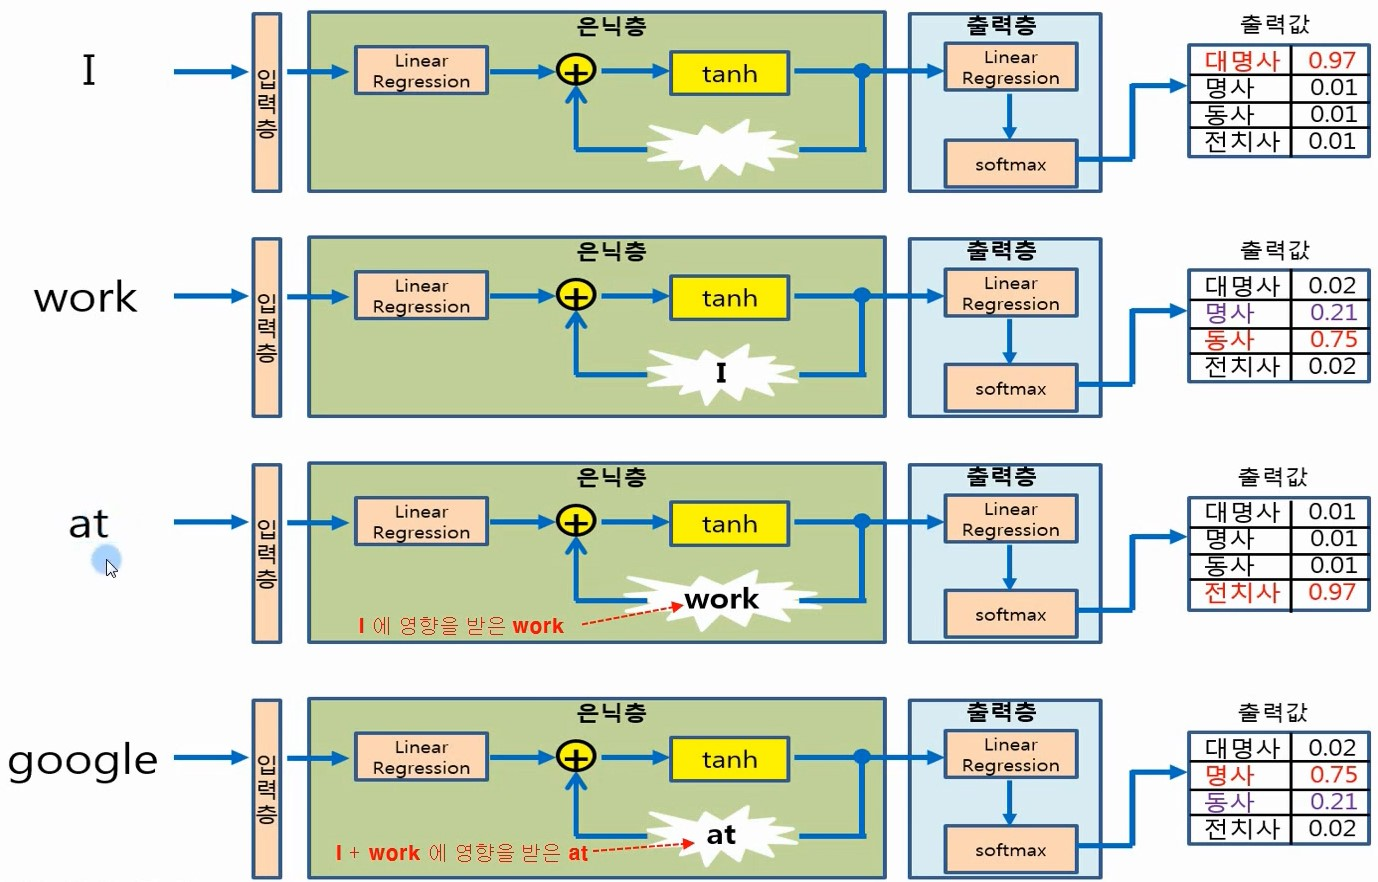

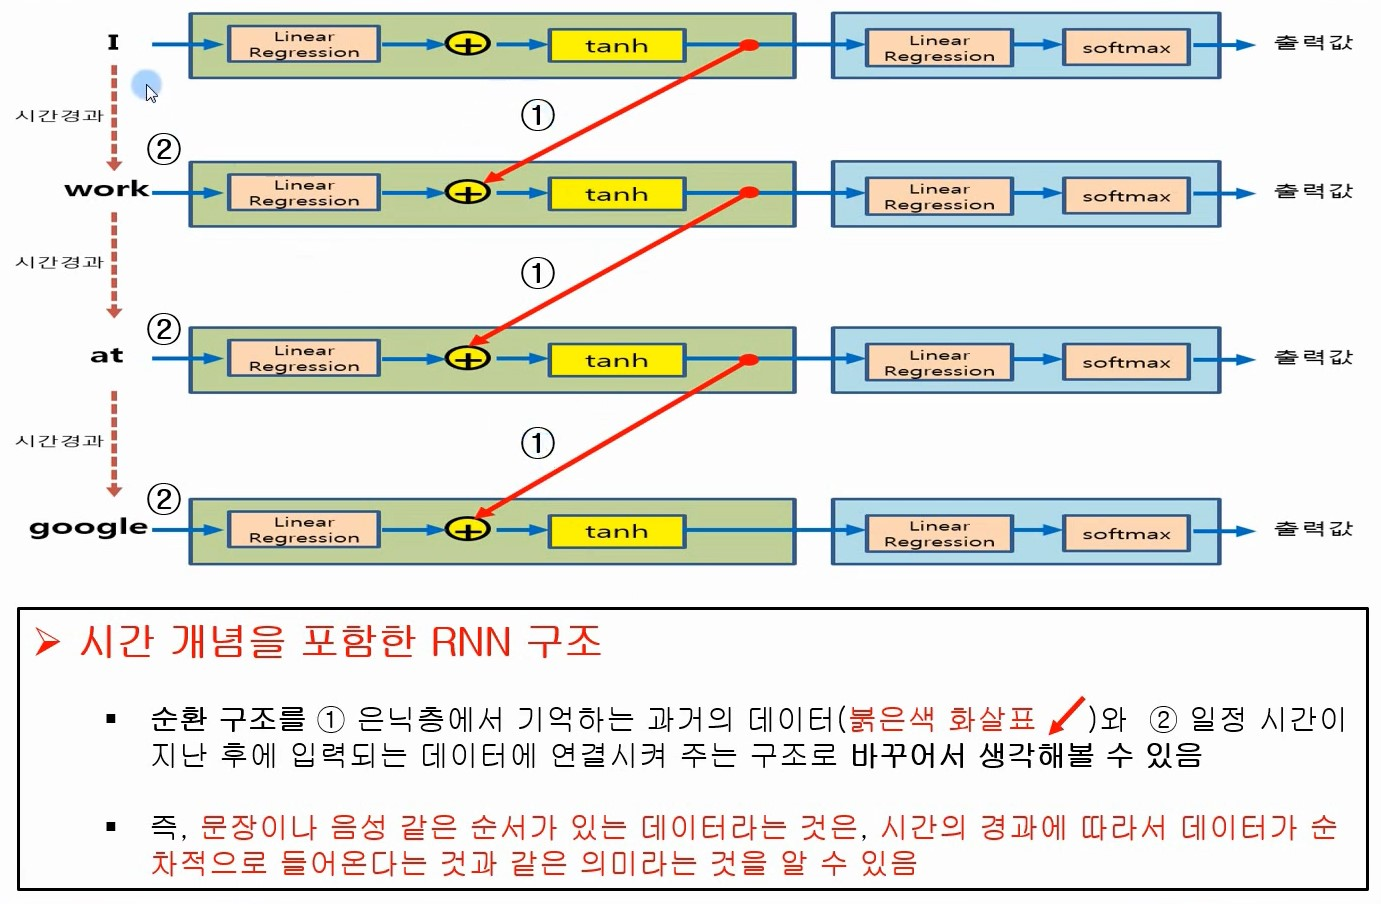

### LSTM(Long Short-Term Memory)
* RNN의 변형이며 RNN이 지닌 다음의 문제를 해결하기 위하여 고안
    - 장기 의존성: n기의 데이터가 n-1기가 아닌, 훨씬 더 과거의 데이터에 더 큰 영향을 받음에도 RNN은 이를 반영하기 힘들다.
    - 그래디언트 문제: RNN은 그 순환구조상 가중치가 반복적으로 곱해지므로 기존 ANN모델보다 그레디언트가 소실/폭발하기 쉽다는 문제를 지닌다.
* LSTM은 정보를 여러 타임스텝에 걸쳐 나르는 방법을 추가하여 시퀀스 어느 지점에서 추출한 정보가 컨베이어 벨트 위로 올라가 필요한 시점의 타임스탭으로 이동하여 떨굼으로써 장기 의존성 문제를 보완하며, 이 흐름을 통해 다음 출력과 상태를 조절함으로써 그래디언트 또한 억제한다.
* 양방향 모델
    - 입력 -> 출력의 순방향 뿐만 아니라 역방향도 살펴보는 방식
    - 시간순서로 생성되는 데이터는 인과관계에 따라 과거에만 의존하기 때문에 순방향만 살펴봐도 되지만, 공간순서에 따라 생성되는 데이터(텍스트 등) 역방향으로도 살펴보는 것이 더 좋은 결과를 만들어 낼 수 있다.
* LSTM은 입력 게이트(Input Gate), 출력 게이트(Out-put Gate), 망각 게이트(Forget Gate)로 보완된 구조를 통해 가중치를 곱한 후 활성화 함수를 거치지 않고 컨트롤 게이트를 통해 상황에 맞게 값을 조절함으로써 문제를 해결한다.

### 원-핫 인코딩된 벡터 시퀀스로 시퀀스 모델 만들기

In [16]:
import tensorflow as tf

# 입력 텐서 정의, None: 가변길이 시퀀스
inputs = keras.Input(shape = (None, ), dtype = 'int64')

# 입력 텐서를 원-핫 인코딩으로 변환; max_tokens=원-핫 인코딩의 차원
# 이를 임베딩 레이어로 사용
embedded = tf.one_hot(inputs, depth = max_tokens)

# 양방향 LSTM 레이어를 정의하고 임베딩 레이어의 출력을 이 레이어에 연결, 유닛 개수는 32
x = layers.Bidirectional(layers.LSTM(32))(embedded)

# 드롭아웃 레이어 생성
x = layers.Dropout(0.5)(x)

# 출력 레이어 생성
outputs = layers.Dense(1, activation = 'sigmoid')(x)

# 모델 생성
model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

# 모델 요약
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [17]:
# 사용자 콜백 작성
callbacks = [
    keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only = True)
]

# 모델 훈련(시간이 상당히 오래 걸리므로 출력결과를 보기위해 epochs를 작게 설정)
# 추후 엔비디아 쿠다를 설치하면 gpu를 이용하여 텐서플로우 딥러닝이 빠르게 가능하다
model.fit(int_train_ds, validation_data = int_val_ds, epochs = 1, callbacks = callbacks)

# best 모델 로드
model = keras.models.load_model('one_hot_bidir_lstm.keras')

# 결과출력
print(f'테스트 정확도: {model.evaluate(int_test_ds)[1]:.3f}')

782/782 [==============================] - 2260s 3s/step - loss: 0.3479 - accuracy: 0.8616
테스트 정확도: 0.862


### 임베딩 레이어로 단어 임베딩 학습하기

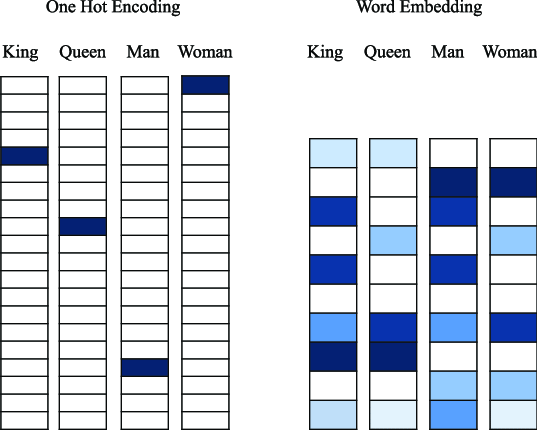

* **워드 임베딩(Word Embedding)**: 학습을 통하여 밀집된 저차원 공간에 텍스트를 표현, 수치 벡터화하는 방법이다. 
* **임베딩 레이어(Embedding Layer)**: 자연어 처리에서 주로 사용되는 신경망 레이어로, 정수로 인코딩된 단어 또는 토큰을 고차원 벡터 공간에 표현하는 역할을 한다.
* 이렇게 변환된 단어 벡터들은 의미론적 관계를 가지며, 이를 통해 단어 간의 유사도를 측정하거나 다양한 자연어 처리 작업에 활용할 수 있다.

|One-hot Encoding|Word Embedding|
|----|----|
|희소|밀집|
|고차원|저차원|
|수동 인코딩|데이터로부터 학습|

In [18]:
# 임베딩 레이어 만들기
# input_dim: 입력 차원 = 가능한 토큰 개수 = max_tokens
# output_dim: 출력할 임베딩 차원 -> 256
embedding_layer = layers.Embedding(input_dim = max_tokens, output_dim = 256)

### 학습하는 임베딩 레이어를 사용한 모델

* tmi: 한글 워드 임베딩에 사용가능한 라이브러리로 Kor2Vec, koBERT, ELMo 등이 있다.

In [19]:
# 레이어 설정
# 입력 텐서 정의
inputs = keras.Input(shape=(None,), dtype="int64")
# 임베딩 레이어 설정
embedded = layers.Embedding(input_dim = max_tokens, output_dim = 256)(inputs)
# 양방향 LSTM 레이어 설정
x = layers.Bidirectional(layers.LSTM(32))(embedded)
# 드롭아웃 레이어
x = layers.Dropout(0.5)(x)
# 출력 레이어
outputs = layers.Dense(1, activation = "sigmoid")(x)

# 모델 생성
model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

# 모델 생성 결과 요약
model.summary()

# 사용자 콜백 작성
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.keras", save_best_only = True)
]

# 모델 학습
model.fit(int_train_ds, validation_data = int_val_ds, epochs = 1, callbacks = callbacks)

# best 모델 로드
model = keras.models.load_model("embeddings_bidir_lstm.keras")

# 결과 출력
print(f"테스트 정확도: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

### 패딩과 마스킹

#### 패딩(Padding)
* 일반적으로 가변 길이의 시퀀스 데이터를 처리할 때 사용되는 기법
* 신경망 모델은 일반적으로 고정 길이의 입력 데이터를 기대하기 때문에, 다양한 길이의 입력 시퀀스를 처리하기 위해 길이 통일이 필요하다.
* 패딩은 짧은 시퀀스에 특정 값을 추가하여 모든 시퀀스의 길이를 동일하게 맞추는 과정이다.
* 텍스트 데이터에서 패딩은 주로 0벡터를 사용하여 진행되며, 이러한 패딩 토큰은 워드 임베딩 과정에서 실제 단어가 아닌 '패딩 토큰'으로 처리한다.
* (ex) 원래 시퀀스: [1, 3, 5] > 옵션 상 최대 길이 5인 시퀀스로 변환 필요 시
패딩 된 시퀀스: [1, 3, 5, 0, 0]

#### 마스킹(Masking)
* 패딩된 시퀀스를 처리할 때, 패딩 토큰은 실제 입력 데이터가 아니기 때문에 모델이 이를 무시하도록 해야하는데, 이를 위해 마스킹 기법을 사용한다.
* 마스킹은 패딩된 부분을 가리고, 모델이 패딩 토큰을 처리하는 동안 손실 및 그레디언트 계산에 영향을 주지 않도록 하는 과정이다.
* 마스킹은 패딩된 시퀀스에 대한 이진 마스크를 생성하여 실제 단어에는 1, 패딩 토큰에는 0을 할당한다.
* 생성된 마스크는 모델에 전달되어 패딩토큰을 무시하도록 한다.
* (ex) 패딩 된 시퀀스: [1, 3, 5, 0, 0]<br>마스크: [1, 1, 1, 0, 0]

마스킹 과정을 아래와 같이 간략하게 볼 수 있다.

In [ ]:
#  원본 데이터    패딩               마스킹
# [1, 3, 5] -> [1, 3, 5, 0, 0] -> [1, 1, 1, 0, 0]
# [1, 3, 5, 0] -> [1, 3, 5, 0, 0] -> [1, 1, 1, 1, 0]

### 마스킹을 활성화한 임베딩 레이어 사용하기

In [23]:
# 레이어 설정
# 입력 텐서 정의
inputs = keras.Input(shape = (None, ), dtype = "int64")    

# 임베딩 레이어 설정
# 마스킹 활성화
embedded = layers.Embedding(input_dim = max_tokens, output_dim = 256, mask_zero = True)(inputs)
# 양방향 LSTM 레이어 설정
x = layers.Bidirectional(layers.LSTM(32))(embedded)
# 드롭아웃 레이어
x = layers.Dropout(0.5)(x)
# 출력 레이어
outputs = layers.Dense(1, activation="sigmoid")(x)

# 모델 생성
model = keras.Model(inputs, outputs)

# 모델 컴파일
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# 사용자 콜백
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm_with_masking.keras", save_best_only=True)
]

# 모델 학습
model.fit(int_train_ds, validation_data = int_val_ds, epochs = 1, callbacks = callbacks)

# best 모델 로드
model = keras.models.load_model("embeddings_bidir_lstm_with_masking.keras")

# 결과 출력력
print(f"테스트 정확도: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________